This notebook introduces some basic concepts of federated learning. Specifically, we look at Federated Averaging, introduced by McMahan et al. in [Communication-Efficient Learning of Deep Networks from Decentralized Data](https://proceedings.mlr.press/v54/mcmahan17a?ref=https://githubhelp.com).



In [66]:
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

from pathlib import Path
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import torch
from torch import nn, optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from torchvision import transforms

from fedlearn.model import SmallCNN

sns.set

<function seaborn.rcmod.set(*args, **kwargs)>

In [ ]:
# set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# set paths for data and logs
datadir = Path().cwd().parent / "data"
logdir = Path().cwd().parent / "logs" / "fedavg"

if not logdir.exists():
    logdir.mkdir(parents=True, exist_ok=True)

We do some typical data preprocessing, and split the data into training, validation and test datasets.

In [7]:
# define the transformation of the data. 
transform = transforms.Compose(
    [transforms.ToTensor(),     # convert the image to a pytorch tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalise the image with mean and std of 0.5

batch_size = 64     # define the batch size

trainset = CIFAR10(root=datadir, train=True,
                   download=True, transform=transform)

# split the training set into 80% training and 20% validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

train_dataset, val_dataset = random_split(trainset, [train_size, val_size]) #generate random training and validation sets

valloader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=0)

# load test data
testset = CIFAR10(root='./data', train=False,
                  download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=0)


# define classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

The goal here is to create a an object that represents the clients. To simulate real world applications, the clients must at least maintain
1. Their own local data
2. A local copy of the model

Furthermore, all clients should be able to perform local updates given the current global model. This update must be communicated with the server. For pytorch models, we can share the model parameters using the ```state_dict()``` method. This returns a dictionary of all learnable parameters and buffers, which we need for updating the global model in federated learning.

Below you will find a simple implementation of this.

In [67]:
class Client:
    '''
    Class that represents clients in a federated learning system.
    The client should maintain a fixed local dataset, and
    contain a method that can be called to train the model locally
    when participating in a round of federated learning.
    '''

    def __init__(self, 
                 net        : nn.Module, 
                 dataset    : Dataset, 
                 batch_size : int, 
                 optimizer  : optim.Optimizer, 
                 criterion  : nn.Module, 
                 lr         : Optional[float] = 1e-3, 
                 device     : Optional[str] = None,
                 ) -> None:
        '''
        Constructor for the Client class.
        Parameters
            net:         the neural network model
            dataset:     the local dataset
            batch_size:  the batch size to use for training
            optimizer:   the optimizer to use for training (class constructor, e.g., optim.SGD)
            criterion:   the loss function to use for training (of form L(X,Y) -> R, eg., nn.MSELoss())
            lr:          the learning rate to use for training
            device:      the device to run the training on (cpu or cuda)
        '''
        self.net = net
        self.optimizer = optimizer(self.net.parameters(), lr=lr)
        self.data = dataset
        self.batch_size = batch_size
        self.criterion = criterion

        # set device to run the training on
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # create a DataLoader for the local dataset
        self.dataloader = DataLoader(dataset, batch_size=batch_size,
                                    shuffle=True, num_workers=0)
        

    def train(self, 
              epochs        : int, 
              state_dict    : dict[torch.Tensor],
              ) -> tuple[dict, float]:
        '''
        Training method that trains the model on the local dataset for a number of epochs.
        Parameters
            epochs:      the number of epochs to train
            state_dict:  the state dictionary of the global model

        Returns
            params:      the state dictionary of the local model after training
            avg_loss:    the average loss over the final epoch after training
        '''

        self.net.to(self.device)                            # move model to device
        self.net.load_state_dict(state_dict, strict=False)  # load global weights
        self.net.train()                                    # set model to train mode

        for epoch in range(epochs):     # iterate thru local epochs
            
            epoch_loss = 0
            for Xtrain, Ytrain in self.dataloader:     # iterate thru local data (mini-batches)
                Xtrain, Ytrain = Xtrain.to(self.device), Ytrain.to(self.device)

                outputs = self.net(Xtrain)

                self.optimizer.zero_grad()
                loss = self.criterion(outputs, Ytrain)
                loss.backward()
                self.optimizer.step()
            
                epoch_loss += loss.item()

        params = copy.deepcopy(self.net.state_dict()) # get the parameters of the model
        avg_loss = epoch_loss / len(self.dataloader) # average loss over the local dataset

        self.net.to("cpu")      # move model back to cpu

        return params, avg_loss

Next, we need to specify the "policy". In our case, we are interested in the Federated Averaging algorithm. Therefore, we need a function that aggregates the local updates into the global update. If the data is IID in the sense that each client has the same size dataset, then the global update is simply the mean of all local updates. If this is not the case, then we must weight each local update according to the size of the dataset.

In [68]:
def aggregate_fedavg(
        param_list : list[dict[torch.Tensor]], 
        weights : Optional[torch.Tensor] = None,
        ) -> dict[torch.Tensor]:
    '''
    Function that averages the weights of the models in the input list.
    parameters:
        param_list:     list of parameter dictionaries of the models to average
        weights:         list of weights to use for the averaging

    Returns
        fed_avg:         the federated averaged state dictionary
    '''
    
    # if no weights are provided, use equal weights
    if weights is None:
        weights = torch.ones(len(param_list)) / len(param_list) 

    fed_avg = {}
    for key in param_list[0].keys():  # iterate through the keys of the state dictionaries
        for i in range(len(param_list)):
            if i == 0:
                fed_avg[key] = param_list[i][key] * weights[i]
            else:
                fed_avg[key] += param_list[i][key] * weights[i]

    return fed_avg

In a real use case, we would define a server class or script as well, which handles the synchronisation of client updates and redistributes the current global model. In this notebook, the server-side operations are handled within the next few cells. Concretely, the server must

1. Initialise the global model
2. select a subset of clients to participate each round
3. Communicate the current global model to the subset of clients in each round
4. Aggregate the local updates each round

In [ ]:
NUM_CLIENTS = 10          # number of clients
IID_DATA = True          # whether the data is IID or not
NUM_ROUNDS = 50          # number of rounds of federated learning
NUM_LOCAL_EPOCHS = 2     # number of local epochs
C = 1.                   # fraction of clients to use per round
CLIENTS_PER_ROUND = int(NUM_CLIENTS * C)    # number of clients to use per round
LR = 1e-3                      # learning rate
DATA_SIZE = len(train_dataset)  # size of the training dataset

# name of each simulation for logging purposes
SIM_NAME = f"N_{NUM_CLIENTS}_C_{C}_R_{NUM_ROUNDS}_LE_{NUM_LOCAL_EPOCHS}_IID_{IID_DATA}"

# define model loss function
criterion = nn.CrossEntropyLoss()

# set device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set device to run the training on

#create indices for each client
if IID_DATA:
    client_indices = torch.tensor_split(torch.randperm(DATA_SIZE), NUM_CLIENTS)
else:
    raise NotImplementedError("Non-IID data not implemented")

clients = [
    Client(net=SmallCNN(), 
           dataset=Subset(train_dataset, indices), 
           batch_size=batch_size, 
           optimizer=optim.Adam,
           criterion=criterion, 
           lr=LR,
           device=device)
    for indices in client_indices
]

print(f"Samples per client: {len(client_indices[0]):d}")
print(f"Clients per round: {CLIENTS_PER_ROUND:d}")

Samples per client: 4000
Clients per round: 10


### Simulation of Federated Learning

In [64]:
net = SmallCNN()                                    # initialize the global model
global_weights = copy.deepcopy(net.state_dict())    # get the parameters of the global model

valid_every = 1 # how often to validate the model

avg_test_loss = []
valid_accs = []
print("Round\t Training Loss\t Validation Accuracy")
for round in range(NUM_ROUNDS):     # iterate thru rounds

    # server selects a random subset of clients to participate in this round
    client_ids = torch.randperm(NUM_CLIENTS)[:CLIENTS_PER_ROUND].tolist() 

    param_list = []         # list to store the parameters of the local models
    aggr_loss = 0           # loss aggregator for the local models

    for id in client_ids:   # iterate thru clients
        param, loss = clients[id].train(NUM_LOCAL_EPOCHS, global_weights)
        param_list.append(param)
        aggr_loss += loss

    avg_test_loss.append(aggr_loss / CLIENTS_PER_ROUND)  # average loss over the local models
    
    global_weights = aggregate_fedavg(param_list)  # aggregate the local weights

    # Validate the mdel every `valid_every` rounds
    if round % valid_every == valid_every - 1:
        net.to(device)
        net.load_state_dict(global_weights)
        net.eval()

        correct = 0
        total = 0

        with torch.no_grad():
            for (images, labels) in valloader:
                images, labels = images.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        valid_acc = correct / total
        valid_accs.append(valid_acc)

        print(f"{round+1}:\t {avg_test_loss[-1]:.3f}\t\t {100 * valid_acc:.2f}%")



Round	 Training Loss	 Validation Accuracy
1:	 1.735		 34.07%
2:	 1.481		 49.02%
3:	 1.309		 54.67%
4:	 1.168		 59.14%
5:	 1.058		 62.27%
6:	 0.951		 64.25%
7:	 0.861		 66.32%
8:	 0.788		 67.85%
9:	 0.709		 69.23%
10:	 0.638		 70.33%
11:	 0.568		 71.27%
12:	 0.519		 71.78%
13:	 0.462		 72.15%
14:	 0.416		 72.97%
15:	 0.379		 73.26%
16:	 0.338		 73.71%
17:	 0.303		 73.91%
18:	 0.275		 73.86%
19:	 0.252		 73.94%
20:	 0.235		 74.34%
21:	 0.213		 74.34%
22:	 0.200		 74.21%
23:	 0.189		 74.03%
24:	 0.165		 74.31%
25:	 0.163		 74.26%
26:	 0.146		 74.23%
27:	 0.143		 74.49%
28:	 0.141		 74.41%
29:	 0.132		 74.07%
30:	 0.124		 74.49%
31:	 0.116		 74.39%
32:	 0.115		 74.05%
33:	 0.122		 74.28%
34:	 0.105		 74.13%
35:	 0.109		 74.29%
36:	 0.112		 73.88%
37:	 0.090		 74.10%
38:	 0.096		 74.09%
39:	 0.098		 73.75%
40:	 0.095		 73.72%
41:	 0.085		 74.03%
42:	 0.096		 74.07%
43:	 0.091		 74.15%
44:	 0.083		 74.02%
45:	 0.081		 73.82%
46:	 0.081		 73.69%
47:	 0.081		 74.29%
48:	 0.080		 74.00%
49:	 0.

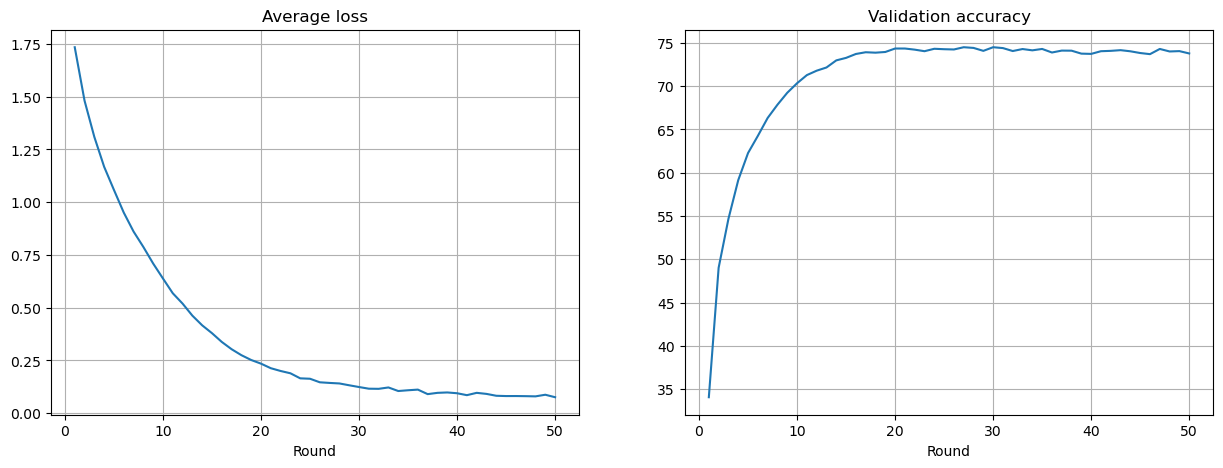

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(np.arange(1, len(avg_test_loss)+1), np.array(avg_test_loss))
axs[0].set_title("Average loss")

axs[1].plot(np.arange(1, len(valid_accs)+1) , 100 * np.array(valid_accs))
axs[1].set_title("Validation accuracy")

for ax in axs:
    ax.set_xlabel("Round")
    ax.grid()

plt.savefig(logdir / f"{SIM_NAME}.png", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
net = SmallCNN().to(device)
net.load_state_dict(torch.load("data/models/fedavg_cifar10.pth", weights_only=True))

net.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for (images, labels) in testloader:
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for (images, labels) in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 75 %
Accuracy for class: plane is 78.9 %
Accuracy for class: car   is 88.7 %
Accuracy for class: bird  is 60.4 %
Accuracy for class: cat   is 52.7 %
Accuracy for class: deer  is 75.2 %
Accuracy for class: dog   is 66.3 %
Accuracy for class: frog  is 85.5 %
Accuracy for class: horse is 82.0 %
Accuracy for class: ship  is 85.6 %
Accuracy for class: truck is 84.1 %
